## Notebook for creating evaluation plots
Note: To run this notebook, please install the ipykernel package.

In [37]:
import h5py
import numpy as np
import matplotlib.pyplot as plt

In [38]:
def draw_plus_symbol(image, x, y, size=6, thickness=1):
    # Calculate the coordinates of the plus symbol
    x_start = max(0, x - size)
    x_end = min(image.shape[1], x + size + 1)
    y_start = max(0, y - thickness // 2)
    y_end = min(image.shape[0], y + thickness // 2 + 1)

    # Draw horizontal line
    image[y_start:y_end, x_start:x_end] = [0, 0, 1]

    # Calculate the coordinates of the vertical line
    y_start = max(0, y - size)
    y_end = min(image.shape[0], y + size + 1)
    x_start = max(0, x - thickness // 2)
    x_end = min(image.shape[1], x + thickness // 2 + 1)

    # Draw vertical line
    image[y_start:y_end, x_start:x_end] = [0, 0, 1]

    return image


In [39]:
# Define coordinates of ROI
x_index = 204
y_index = 245
# Define number of spokes for spatial resolution and resulting time frames
n_spokes = 13
n_frames = 22

In [40]:
file = h5py.File('../runs/base_varnet_layer-03_iter-05_epoch-040_loss-MSE_optim-Adam_lr-0.010000/test/recon_001.h5', "r")
# Return datasets as a numpy array
gt = file['gt'][()]
recon = file['recon'][()]

In [41]:
# Sum over the time dimension and squeeze the arrays
summed_gt = np.squeeze(np.sum(gt, axis=1))
summed_recon = np.squeeze(np.sum(recon, axis=1))

# Normalize both arrays
max_gt = np.max(summed_gt)
min_gt = np.min(summed_gt)
summed_gt = (summed_gt - min_gt) / (max_gt - min_gt)

max_recon = np.max(summed_recon)
min_recon = np.min(summed_recon)
summed_recon = (summed_recon - min_recon) / (max_recon - min_recon)

In [42]:
# Add color dimension and draw ROI
summed_gt = np.repeat(summed_gt[:, :, np.newaxis], 3, axis=2)
summed_gt = draw_plus_symbol(summed_gt, x_index, y_index)

summed_recon = np.repeat(summed_recon[:, :, np.newaxis], 3, axis=2)
summed_recon = draw_plus_symbol(summed_recon, x_index, y_index)

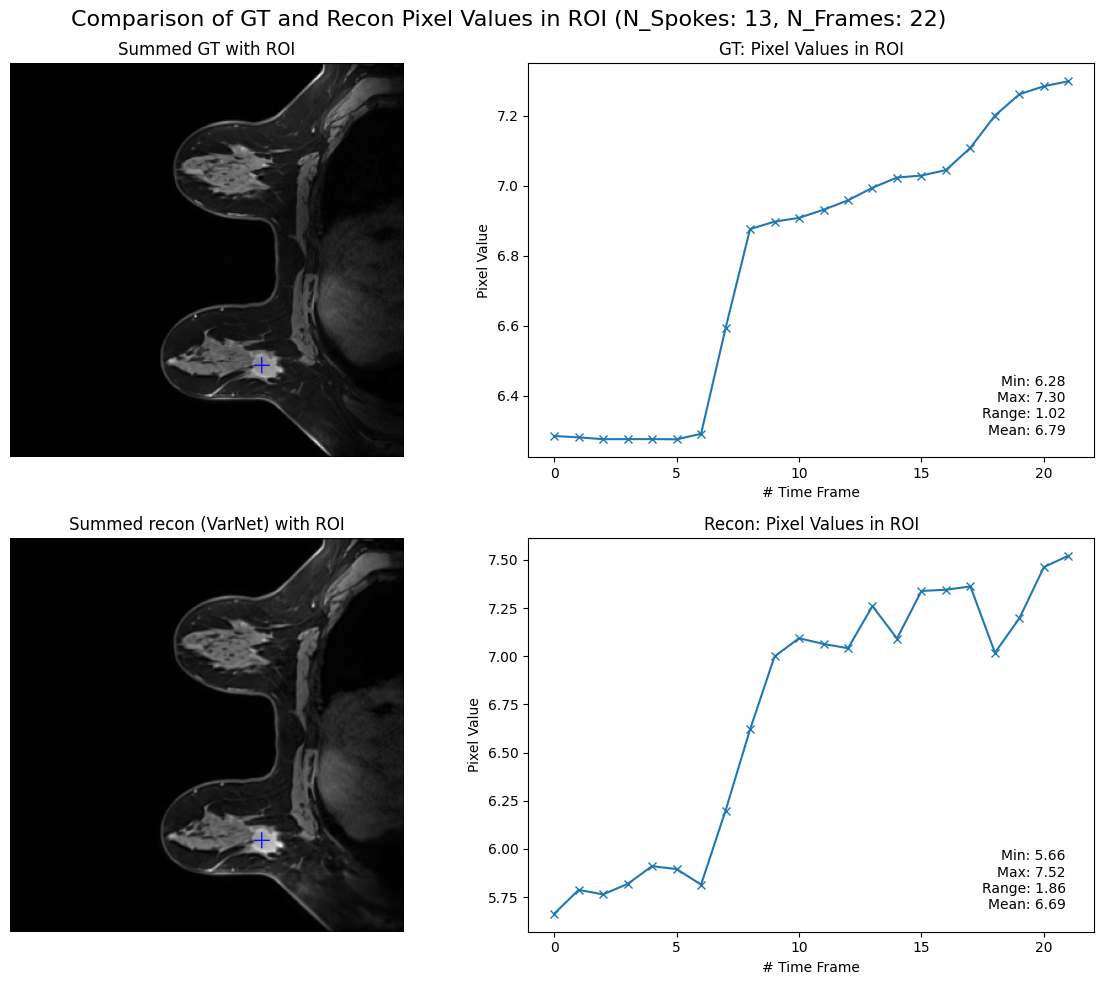

In [43]:
# Create a new figure
plt.figure(figsize=(12, 10))

# Add a large title above all subfigures
plt.suptitle(f'Comparison of GT and Recon Pixel Values in ROI (N_Spokes: {n_spokes}, N_Frames: {n_frames})', fontsize=16)

# Plot 1: Summed gt with ROI
plt.subplot(2, 2, 1)
plt.imshow(summed_gt)
plt.title('Summed GT with ROI')
plt.axis('off')

# Plot 2: Gt Pixel Values in ROI
plt.subplot(2, 2, 2)
pixel_values = gt[0, :, x_index, y_index]
plt.plot(pixel_values, '-x')
plt.title('GT: Pixel Values in ROI')
plt.xlabel('# Time Frame')
plt.ylabel('Pixel Value')
min_val = pixel_values.min()
max_val = pixel_values.max()
range_val = max_val - min_val
mean_val = np.mean(pixel_values)
plt.text(0.95, 0.05, f"Min: {min_val:.2f}\nMax: {max_val:.2f}\nRange: {range_val:.2f}\nMean: {mean_val:.2f}",
         horizontalalignment='right', verticalalignment='bottom',
         transform=plt.gca().transAxes, fontsize=10)

# Plot 3: Summed recon (VarNet) with ROI
plt.subplot(2, 2, 3)
plt.imshow(summed_recon)
plt.title('Summed recon (VarNet) with ROI')
plt.axis('off')

# Plot 4: Recon Pixel Values in ROI
plt.subplot(2, 2, 4)
pixel_values = recon[0, :, x_index, y_index]
plt.plot(pixel_values, '-x')
plt.title('Recon: Pixel Values in ROI')
plt.xlabel('# Time Frame')
plt.ylabel('Pixel Value')
min_val = pixel_values.min()
max_val = pixel_values.max()
range_val = max_val - min_val
mean_val = np.mean(pixel_values)
plt.text(0.95, 0.05, f"Min: {min_val:.2f}\nMax: {max_val:.2f}\nRange: {range_val:.2f}\nMean: {mean_val:.2f}",
         horizontalalignment='right', verticalalignment='bottom',
         transform=plt.gca().transAxes, fontsize=10)

# Adjust layout
plt.tight_layout()

# Show the figure
plt.show()